In [38]:
from utils.plot_line import plot_line_graph
from utils.normalize import normalize
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

            consumer_sentiment_pca  googletrends_pca  ipo_count  Price  \
date                                                                     
1986-04-01                0.289038          0.015134        0.0   0.00   
1986-05-01                0.812365          0.015134        0.0   0.00   
1986-06-01                1.502533          0.015134        0.0   0.00   
1986-07-01                1.921345          0.015134        0.0   0.00   
1986-08-01                2.010434          0.015134        0.0   0.00   
1986-09-01                2.064544          0.015134        0.0   0.00   
1986-10-01                2.091105          0.015134        0.0   0.00   
1986-11-01                2.063866          0.015134        0.0   0.00   
1986-12-01                1.978271          0.015134        0.0   0.00   
1987-01-01                2.167354          0.015134        0.0   0.00   
1987-02-01                2.345863          0.015134        0.0   0.00   
1987-03-01                2.256693    

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Variables by month plus PCA'}, xlabel='date', ylabel='Normalized variables [-5, 5]'>)

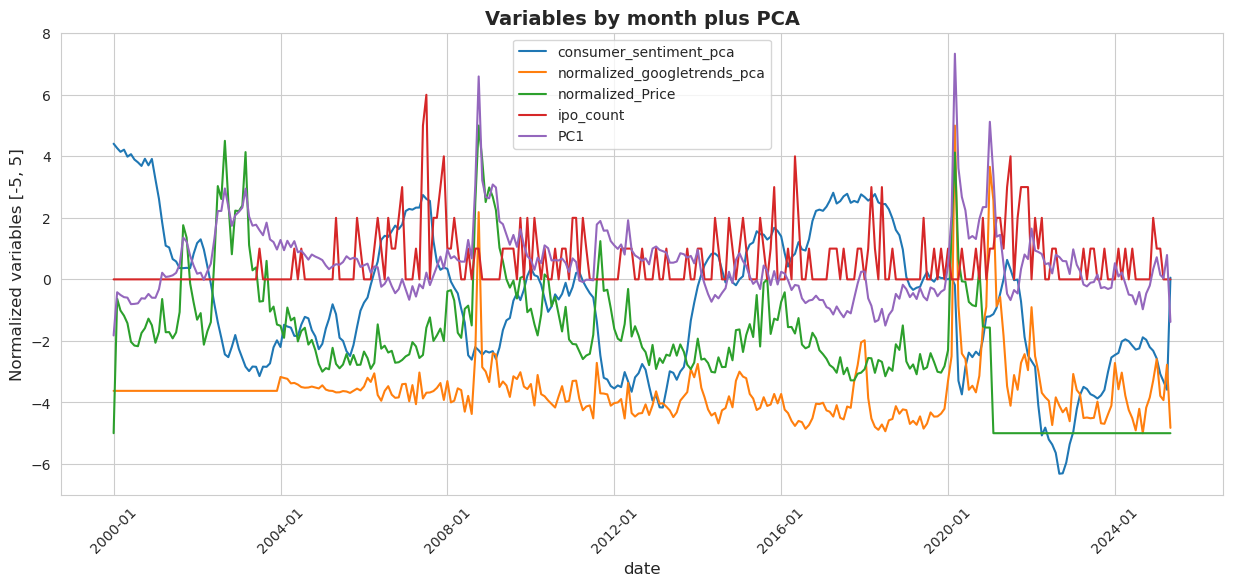

In [41]:

cs_df = pd.read_csv('consumersentiment/consumer_sentiment_pca.csv')
google_df= pd.read_csv('googletrends/googletrends_pca_output.csv')
vaex_df= pd.read_csv('vaex/investing.comVAEXmonthly.csv')
ipo_df= pd.read_csv('ipo/euronextIPOAms.csv')

for df in [cs_df, google_df, vaex_df, ipo_df]:
    df['date'] = pd.to_datetime(df['date'])

vaex_df['date'] = pd.to_datetime(vaex_df['date'], format='%m/%d/%Y')
    
ipo_df = ipo_df[["ipo_count", "date"]]

merged_df = pd.merge(cs_df, google_df, on='date', how='outer')
merged_df = pd.merge(merged_df, ipo_df, on='date', how='outer')

merged_df = pd.merge(merged_df, vaex_df, on='date', how='outer')

merged_df.set_index('date', inplace=True)

merged_df = merged_df.drop(columns=['Change', 'Open', 'High', 'Low'])

count_col = merged_df['ipo_count']
price_col = merged_df["Price"]


imputer = SimpleImputer(strategy='mean')
cols_to_impute = merged_df.columns.difference(['ipo_count', 'Price'])
merged_df[cols_to_impute] = imputer.fit_transform(merged_df[cols_to_impute])

merged_df['ipo_count'] = count_col.fillna(0)
merged_df['Price'] = price_col.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df)

# print(X_scaled[:200])

pca = PCA(n_components=1)
first_pc = pca.fit_transform(X_scaled)

df_pc1 = pd.DataFrame(first_pc, columns=['PC1'])

df_pc1.index = merged_df.index
merged_df['PC1'] = df_pc1['PC1']

merged_df = normalize(merged_df, 'Price')
merged_df = normalize(merged_df, 'googletrends_pca')

print(merged_df)

merged_df = merged_df[merged_df.index >= pd.to_datetime('2000-01-01')]

plot_line_graph(
            df=merged_df.reset_index(),
            x_column='date',
            y_column=['consumer_sentiment_pca', 'normalized_googletrends_pca', 'normalized_Price','ipo_count','PC1'],
            title='Variables by month plus PCA',
            xlabel='date',
            ylabel='Normalized variables [-5, 5]',
            grid=True
)